# Visualize

Notebook to prototype visualization

pip install descartes

In [42]:
from genophenocorr.view import TxJsonFileRetriever
retriever = TxJsonFileRetriever(directory_location="/Users/robinp/GIT/genophenocorr/tests/data/")
json_data_hbb = retriever.retrieve("NM_000518.4")
json_data_ptpn11 = retriever.retrieve('NM_002834.5')

from genophenocorr.view import VvTranscriptModel
vvt_model = VvTranscriptModel(json_data_ptpn11)

Extracted 16 exons
Extracted 16 exons
Extracted 11 exons
Extracted 16 exons
Extracted 16 exons
Could not retrieve hg38 genomic span from VariantValidator JSON data
Extracted 16 exons
Extracted 11 exons
Extracted 11 exons
Extracted 16 exons
[INFO] retrieved 10 transcript models from VariantValidator


In [43]:
print(vvt_model)
transcript1 = vvt_model.get_most_relevant_transcript()
print(transcript1)
for ex in transcript1.get_exon_list():
    print(f"\t{ex}")

[VvTranscriptModel] PTPN11: protein tyrosine phosphatase non-receptor type 11 (HGNC:9644); requested NM_002834.5. Transcripts: n=10
[VvTranscript] NM_002834.5-CDS: 166-1947, chrom: 12 length 6073 nt transl NP_002825.3: MANE select
	[VvExon] exon 1: 1-179
	[VvExon] exon 2: 180-302
	[VvExon] exon 3: 303-497
	[VvExon] exon 4: 498-690
	[VvExon] exon 5: 691-807
	[VvExon] exon 6: 808-921
	[VvExon] exon 7: 922-1018
	[VvExon] exon 8: 1019-1098
	[VvExon] exon 9: 1099-1257
	[VvExon] exon 10: 1258-1389
	[VvExon] exon 11: 1390-1544
	[VvExon] exon 12: 1545-1612
	[VvExon] exon 13: 1613-1764
	[VvExon] exon 14: 1765-1877
	[VvExon] exon 15: 1878-1979
	[VvExon] exon 16: 1980-6073


# Now collect cohort data

In [44]:
from genophenocorr.preprocessing import configure_caching_patient_creator

import hpotk
hpo_uri = "../../../data/hpo/hp.json"
hpo = hpotk.load_minimal_ontology(hpo_uri)
print(f'Loaded HPO v{hpo.version}')
patient_creator = configure_caching_patient_creator(hpo)

Loaded HPO v2023-10-09


In [45]:
import os
print(os.getcwd())

/Users/robinp/GIT/genophenocorr/notebooks


In [46]:
import os

from google.protobuf.json_format import Parse
from phenopackets import Phenopacket

fpath_pp_dir = '../../phenopacket-store/notebooks/PTPN11/phenopackets/'

ptpn11_individuals = []

for dirpath, dirnames, filenames in os.walk(fpath_pp_dir):
    for filename in filenames:
        if filename.endswith('.json'):
            fpath_pp = os.path.join(dirpath, filename)
            pp = Phenopacket()
            with open(fpath_pp) as fh:
                Parse(fh.read(), pp)
            patient = patient_creator.create_patient(pp)
            ptpn11_individuals.append(patient)

print(f'Loaded {len(ptpn11_individuals)} individuals with variants in PTPN11')

Loaded 42 individuals with variants in PTPN11


In [47]:
from genophenocorr.model import Cohort
from genophenocorr.view import CohortViewer
from IPython.display import display, HTML
ptpn11_cohort = Cohort.from_patients(ptpn11_individuals)
#cohort.all_patients
viewer = CohortViewer(hpo=hpo)
display(HTML(viewer.cohort_summary_table(ptpn11_cohort)))

Item,Description
Total Individuals,42
Total Unique HPO Terms,57
Total Unique Variants,42


In [48]:
# av is a set of genophenocorr.model._variant.Variant
av = ptpn11_cohort.all_variants

In [70]:
from typing import Set, List, Tuple
from collections import defaultdict
from genophenocorr.model import Variant, TranscriptAnnotation
from genophenocorr.view import VvTranscript
from pprint import pprint

class VariantView:
    """POJO class that has all information we need to plot this Variant"""
    def __init__(self, var:Variant,  tannot:TranscriptAnnotation ):
        #print(var)
        if not isinstance(var, Variant):
            raise ValueError(f"var argument must be Variant but was {type(var)}")
        if not isinstance(tannot, TranscriptAnnotation):
            raise ValueError(f"tannot argument must be TranscriptAnnotation but was {type(var)}")
        self._genomic_coordinates = var.variant_coordinates
        self._variant_effects = tannot.variant_effects
        self._hgvs_cdna = tannot.hgvsc_id
        self._hgvs_p = "WHERE IS THIS"
        self._overlapping_exons = tannot.overlapping_exons # a tuple with all exons touched by the mutation
        self._protein_effect_loc = tannot.protein_effect_location

    @property
    def ucsc_contig(self):
        """
        Returns:
            the chromosome: a string such as chr12 or chrX
        """
        return self._genomic_coordinates.region.contig.ucsc_name

    @property
    def genomic_start(self) -> int:
        return self._genomic_coordinates.region.start

    @property
    def genomic_end(self) -> int:
        return self._genomic_coordinates.region.end

    @property
    def strand(self) -> int:
        return self._genomic_coordinates.region.strand

    @property
    def genomic_ref(self) -> int:
        return self._genomic_coordinates.ref

    @property
    def genomic_alt(self) -> int:
        return self._genomic_coordinates.alt

    @property
    def genomic_change_len(self) -> int:
        return self._genomic_coordinates.change_length

    @property
    def protein_start(self):
        return self._protein_effect_loc.start

    @property
    def protein_end(self):
        return self._protein_effect_loc.end

    @property
    def hgvs_cdna(self):
        return self._hgvs_cdna




In [71]:
class ProteinVariantVisualiser:
    def __init__(self, variant_set:Set[Variant], tx:VvTranscript, prot_len):
        if not isinstance(variant_set, set):
            raise ValueError(f"variant_set argument must be a set but was {type(variant_set)}")
        self._variant_set = variant_set
        self._reference_tx = tx
        self._variant_view_list = self._filter_variants()
        self._variants_sorted_by_frequency = self._count_variants()
        self._protein_len = prot_len

    def _filter_variants(self):
        """genophenocorr VariantObjects contain transcript annotations for multiple specific transcript. Choose the ones that correspond the reference transcript
        and that have an effect on the protein
        """
        matching_vars = list()
        reference_tx_id = self._reference_tx.reference
        for v in self._variant_set:
            matching_tx = []
            for annot in v.tx_annotations:
                transcript_id = annot.transcript_id
                if transcript_id == reference_tx_id:
                    matching_tx.append(annot)
            # We expect to get exactly one match per variant
            if len(matching_tx) == 0:
                print(f"[WARNING] Could not find annotation of variant {v.variant_coordinates.variant_key} for {reference_tx_id}")
                continue
            elif len(matching_tx) > 1:
                print(f"[WARNING] Found {len(matching_tx)} annotations of variant {v.variant_coordinates.variant_key} for {reference_tx_id}")
                continue
            else:
                # TODO TEMPORARY -- NEED TO ADD LOCATION OF VARIANT IN GENE OR IN TRASNCRIPT; NOT IN PROTEIN
                if matching_tx[0].protein_effect_location is None:
                    continue
                matching_vars.append(VariantView(var=v, tannot=matching_tx[0]))
        print(f"Retrieved {len(matching_vars)} matching transcript annotations for {len(self._variant_set)} variants")
        return sorted(matching_vars, key=lambda x: x.protein_start)


    def _count_variants(self):
        """Count the frequency of the variants in the cohort

        Returns:
            List[Tuple[str, int, Variant]]: List of tuples, with each tuple being a variant and its frequency, sorted in descending order
        """
        var_count_d = defaultdict(int)
        var_d = {}
        for annot in self._variant_view_list:
            var_count_d[annot.hgvs_cdna] += 1
            var_d[annot.hgvs_cdna] = annot
        sorted_variants_by_frequency = sorted(var_count_d.items(), key=lambda x:x[1], reverse=True)
        sorted_triples = []
        for duple in sorted_variants_by_frequency:
            triple = (duple[0], duple[1], var_d.get(duple[0]))
            sorted_triples.append(triple)
        return sorted_triples

    @property
    def reference_transcript(self):
        return self._reference_tx

    @property
    def tx_accession(self):
        return self._reference_tx.reference

    def get_sorted_variants(self):
        return self._variants_sorted_by_frequency

In [72]:
# the length of the ref protein in our example is 593.
# todo -- calculate from exon and CDS data rather than looking up
tv = ProteinVariantVisualiser(variant_set=av, tx=transcript1, prot_len = 593 )

Retrieved 39 matching transcript annotations for 42 variants


# Let's try a very simple plot to warm up


In [73]:
import warnings
from matplotlib import pyplot as plt
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [74]:
import typing
def get_interpolated_location_in_protein(start_in_prot:int, end_in_prot:int, prot_len:int, plot_width:int=1200, margin_size:int=20) -> typing.Tuple[int,int]:
    used_plot_width = plot_width - 2*margin_size
    rel_start_pos_in_prot = start_in_prot / prot_len
    start_x = margin_size + used_plot_width*rel_start_pos_in_prot
    rel_end_pos_in_prot = end_in_prot / prot_len
    end_x = margin_size + used_plot_width*rel_end_pos_in_prot
    return (start_x, end_x)




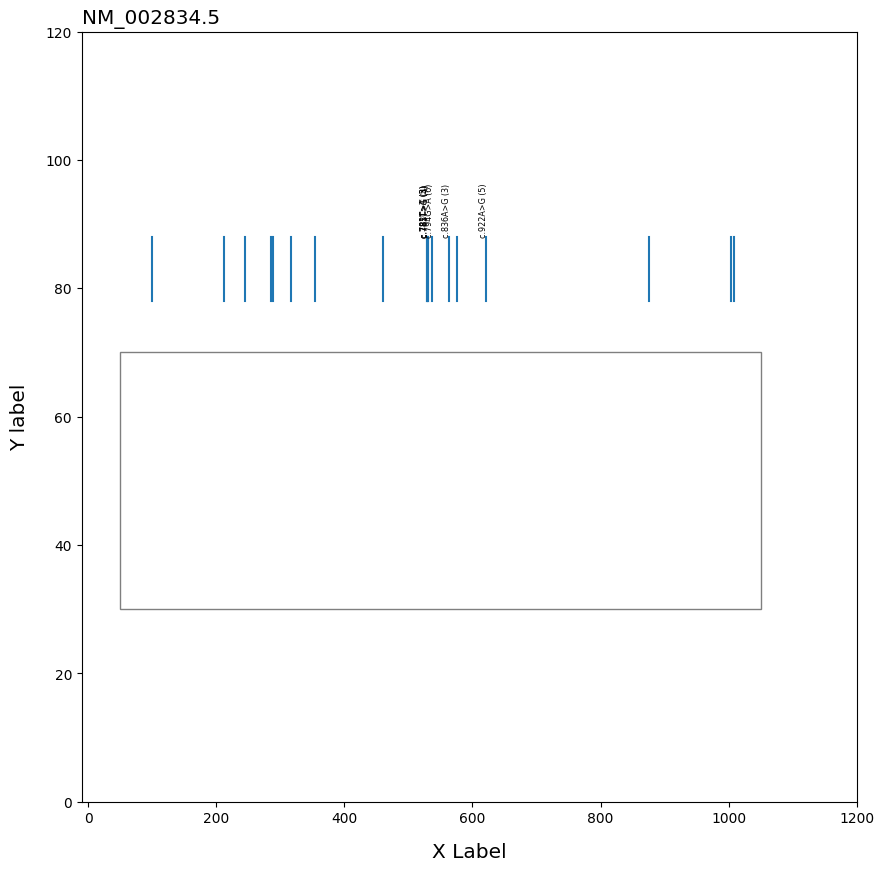

In [75]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D

def create_plot(pviz:ProteinVariantVisualiser):
    title = f"{pviz.tx_accession}"
    fig, ax = plt.subplots(1, figsize=(10, 10))
    THRESHOLD = 2
    BOTTOM_MARGIN = 20
    amino_acid_len = pviz._protein_len
    # draw a box that is ten aax tall, where aax is the dimension of one amino acid
    (prot_start, prot_end) = get_interpolated_location_in_protein(1, amino_acid_len, amino_acid_len)
    box_height = 10/amino_acid_len
    prot_width = prot_end - prot_start + 1
    protein_height = prot_width/20
    #rect = Rectangle((prot_start, BOTTOM_MARGIN), prot_width, protein_height)
    rect = Rectangle((50, 30), 1000, 40, edgecolor='black', facecolor='white', alpha=0.5)
    ax.add_patch(rect)
    for v_tuple in pviz.get_sorted_variants():
        var_id = v_tuple[0]
        freq = v_tuple[1]
        var = v_tuple[2]
        fields = var.hgvs_cdna.split(":")
        if len(fields) > 1:
            mut_name = fields[1]
        else:
            mut_name = fields[0]
        (xpos,JUNK_TODOREFACGTOR) = get_interpolated_location_in_protein(var.protein_start, 0, amino_acid_len)
        x = [xpos, xpos]
        ybase = BOTTOM_MARGIN + protein_height
        ytop = ybase + 10
        y = [ybase, ytop]
        line = Line2D(x, y)
        ax.add_line(line)
        if freq >= THRESHOLD:
            message = f"{mut_name} ({freq})"
            ax.text(x=xpos,y=ybase+10, s=message, fontsize='xx-small', rotation = 90,
         rotation_mode = 'anchor' )
        #print(var.protein_start)

    ax.set_title(title, loc='left', fontsize='x-large')
    ax.set_xlabel('X Label', labelpad=12, fontsize=14.5)
    ax.set_ylabel('Y label', labelpad=12, fontsize=14.5)
    ax.set_xlim(-10, 1200)
    ax.set_ylim(0,120)


create_plot(tv)

In [55]:
help(plt.text)

Help on function text in module matplotlib.pyplot:

text(x, y, s, fontdict=None, **kwargs)
    Add text to the Axes.
    
    Add the text *s* to the Axes at location *x*, *y* in data coordinates.
    
    Parameters
    ----------
    x, y : float
        The position to place the text. By default, this is in data
        coordinates. The coordinate system can be changed using the
        *transform* parameter.
    
    s : str
        The text.
    
    fontdict : dict, default: None
        A dictionary to override the default text properties. If fontdict
        is None, the defaults are determined by `.rcParams`.
    
    Returns
    -------
    `.Text`
        The created `.Text` instance.
    
    Other Parameters
    ----------------
    **kwargs : `~matplotlib.text.Text` properties.
        Other miscellaneous text parameters.
    
        Properties:
        agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and t